In [ ]:


import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway, shapiro, mannwhitneyu
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns


data_path = 'https://raw.githubusercontent.com/daniellim27/InsulinData/refs/heads/main/DATA%202017-23.csv'
df = pd.read_csv(data_path)


df.info()


df.head()





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6100 entries, 0 to 6099
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      6100 non-null   float64
 1   LBXIN     6100 non-null   float64
 2   BMXBMI    6100 non-null   float64
 3   RIAGENDR  6100 non-null   float64
 4   RIDRETH3  6100 non-null   float64
 5   DR2TSUGR  6100 non-null   float64
 6   DR2TKCAL  6100 non-null   float64
 7   DR1TSUGR  6100 non-null   float64
 8   DR1TKCAL  6100 non-null   float64
dtypes: float64(9)
memory usage: 429.0 KB


,SEQN,LBXIN,BMXBMI,RIAGENDR,RIDRETH3,DR2TSUGR,DR2TKCAL,DR1TSUGR,DR1TKCAL
0,109264.0,6.05,17.6,2.0,1.0,89.08,1932.0,27.86,1046.0
1,109271.0,16.96,29.7,1.0,3.0,174.02,3989.0,85.00,2310.0
2,109274.0,13.52,30.2,1.0,7.0,34.13,1302.0,60.84,2385.0
3,109277.0,6.44,18.6,2.0,1.0,73.82,1267.0,73.25,1202.0
4,109282.0,7.49,26.6,1.0,3.0,175.94,2953.0,139.16,2026.0


In [ ]:
df['AvgSugar'] = (df['DR1TSUGR'] + df['DR2TSUGR']) / 2
df['AvgCalories'] = (df['DR1TKCAL'] + df['DR2TKCAL']) / 2
df.head()


,SEQN,LBXIN,BMXBMI,RIAGENDR,RIDRETH3,DR2TSUGR,DR2TKCAL,DR1TSUGR,DR1TKCAL,AvgSugar,AvgCalories
0,109264.0,6.05,17.6,2.0,1.0,89.08,1932.0,27.86,1046.0,58.470,1489.0
1,109271.0,16.96,29.7,1.0,3.0,174.02,3989.0,85.00,2310.0,129.510,3149.5
2,109274.0,13.52,30.2,1.0,7.0,34.13,1302.0,60.84,2385.0,47.485,1843.5
3,109277.0,6.44,18.6,2.0,1.0,73.82,1267.0,73.25,1202.0,73.535,1234.5
4,109282.0,7.49,26.6,1.0,3.0,175.94,2953.0,139.16,2026.0,157.550,2489.5


In [ ]:

print("\nChi-Square Tests for Categorical Variables:")
categorical_features = ['RIAGENDR', 'RIDRETH3']
for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df['LBXIN'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"\nChi-Square Test for {feature}:")
    print(f"Chi2 Statistic: {chi2:.2f}, P-Value: {p:.2f}")


print("\nANOVA for Continuous Variables:")
continuous_features = [ 'AvgSugar', 'AvgCalories', 'BMXBMI']
for feature in continuous_features:
    groups = [df[df['LBXIN'] == label][feature] for label in df['LBXIN'].unique()]
    f_stat, p_value = f_oneway(*groups)
    print(f"\nANOVA for {feature}:")
    print(f"F-Statistic: {f_stat:.2f}, P-Value: {p_value:.2f}")



Chi-Square Tests for Categorical Variables:

Chi-Square Test for RIAGENDR:
Chi2 Statistic: 2570.06, P-Value: 0.29

Chi-Square Test for RIDRETH3:
Chi2 Statistic: 13023.32, P-Value: 0.01

ANOVA for Continuous Variables:

ANOVA for AvgSugar:
F-Statistic: 0.97, P-Value: 0.80

ANOVA for AvgCalories:
F-Statistic: 1.00, P-Value: 0.50

ANOVA for BMXBMI:
F-Statistic: 2.57, P-Value: 0.00


In [ ]:
threshold = 20

df['Diabetes'] = np.where(df['LBXIN'] > threshold, 1, 0)


features_to_exclude = ['LBXIN']

df['Gender'] = (df['RIAGENDR'])
df['Race'] = (df['RIDRETH3'])

selected_features = ['BMXBMI', 'Gender', 'Race', 'AvgSugar', 'AvgCalories', 'Diabetes']
df = df[selected_features]

df.head()


,BMXBMI,Gender,Race,AvgSugar,AvgCalories,Diabetes
0,17.6,2.0,1.0,58.470,1489.0,0
1,29.7,1.0,3.0,129.510,3149.5,0
2,30.2,1.0,7.0,47.485,1843.5,0
3,18.6,2.0,1.0,73.535,1234.5,0
4,26.6,1.0,3.0,157.550,2489.5,0


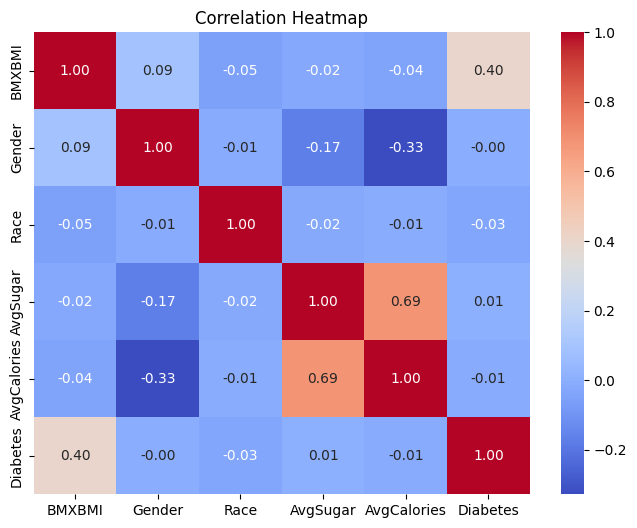

In [ ]:
correlation_matrix = df[['BMXBMI','Gender','Race', 'AvgSugar', 'AvgCalories', 'Diabetes']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

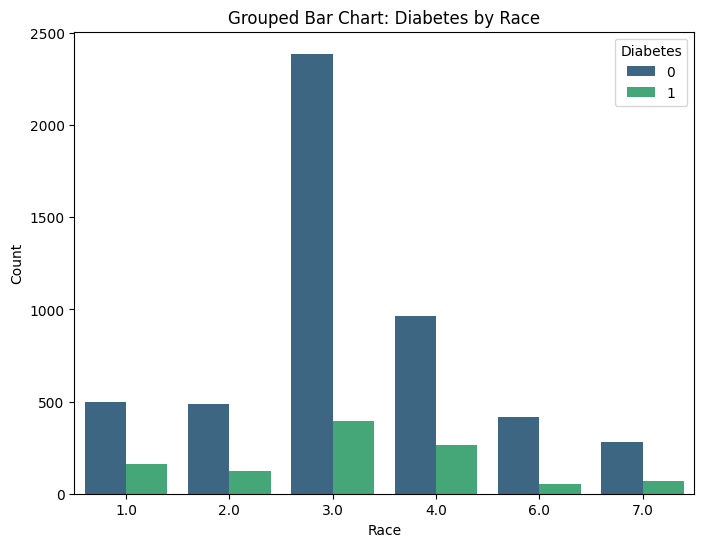

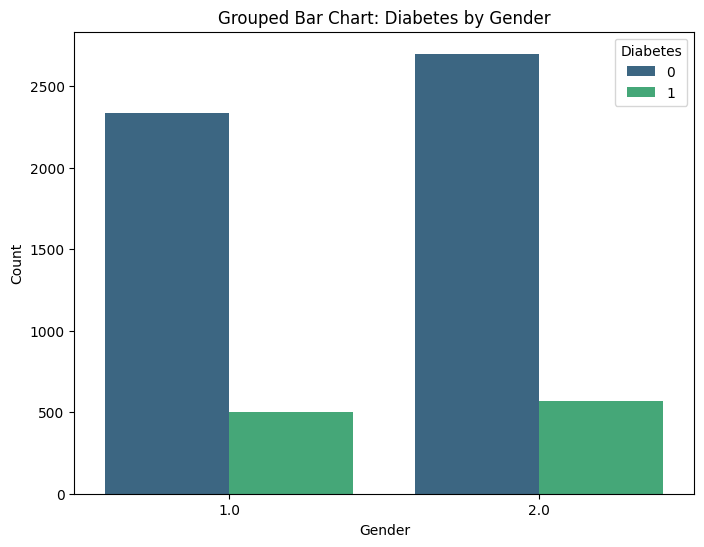

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Race', hue='Diabetes', data=df, palette='viridis')
plt.title('Grouped Bar Chart: Diabetes by Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', hue='Diabetes', data=df, palette='viridis')
plt.title('Grouped Bar Chart: Diabetes by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In [ ]:
#oversampling

X = df.drop(columns=['Diabetes',])
y_diabetes = df['Diabetes']

smote = SMOTE(random_state=42)
X_resampled_diabetes, y_resampled_diabetes = smote.fit_resample(X, y_diabetes)



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:

X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = train_test_split(
    X_resampled_diabetes,
    y_resampled_diabetes,
    test_size=0.8,
    random_state=42
)


Evaluation Metrics for Random Forest (Diabetes):
Accuracy: 0.83
Precision: 0.83
Recall: 0.83
F1 Score: 0.83
ROC-AUC Score: 0.92

Feature Importances for Random Forest:
       Feature  Importance
0       BMXBMI    0.415022
2         Race    0.163773
4  AvgCalories    0.152248
3     AvgSugar    0.148307
1       Gender    0.120650


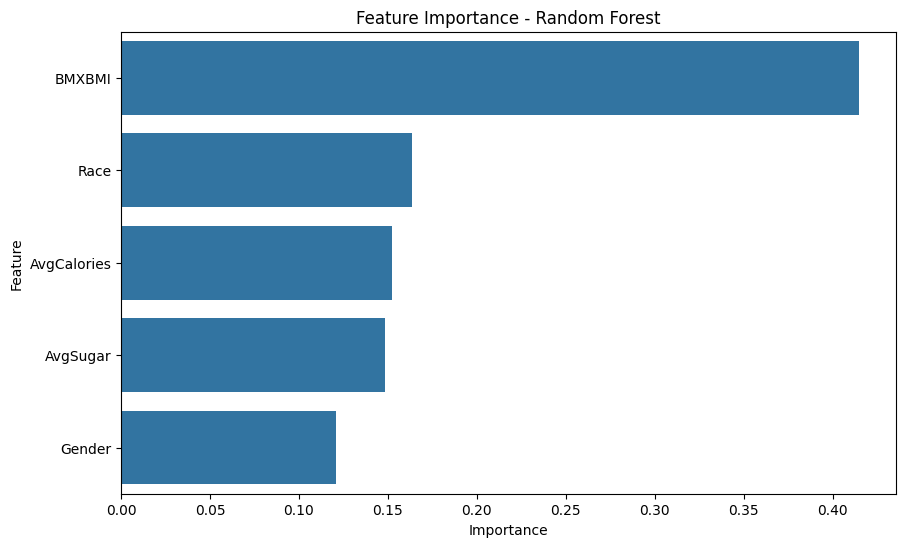

In [ ]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_diabetes, y_train_diabetes)
rf_y_pred = rf_model.predict(X_test_diabetes)
rf_y_proba = rf_model.predict_proba(X_test_diabetes)[:, 1]

print("\nEvaluation Metrics for Random Forest (Diabetes):")
print(f"Accuracy: {accuracy_score(y_test_diabetes, rf_y_pred):.2f}")
print(f"Precision: {precision_score(y_test_diabetes, rf_y_pred):.2f}")
print(f"Recall: {recall_score(y_test_diabetes, rf_y_pred):.2f}")
print(f"F1 Score: {f1_score(y_test_diabetes, rf_y_pred):.2f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test_diabetes, rf_y_proba):.2f}")

# Feature Importances
if hasattr(rf_model, 'feature_importances_'):
    rf_feature_importances = rf_model.feature_importances_
    rf_features = X.columns
    rf_importance_df = pd.DataFrame({'Feature': rf_features, 'Importance': rf_feature_importances}).sort_values(by='Importance', ascending=False)

    print("\nFeature Importances for Random Forest:")
    print(rf_importance_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=rf_importance_df)
    plt.title('Feature Importance - Random Forest')
    plt.show()


Evaluation Metrics for Gradient Boosting (Diabetes):
Accuracy: 0.85
Precision: 0.87
Recall: 0.82
F1 Score: 0.84
ROC-AUC Score: 0.93

Feature Importances for Gradient Boosting:
       Feature  Importance
0       BMXBMI    0.538971
2         Race    0.228717
1       Gender    0.170795
4  AvgCalories    0.031283
3     AvgSugar    0.030235


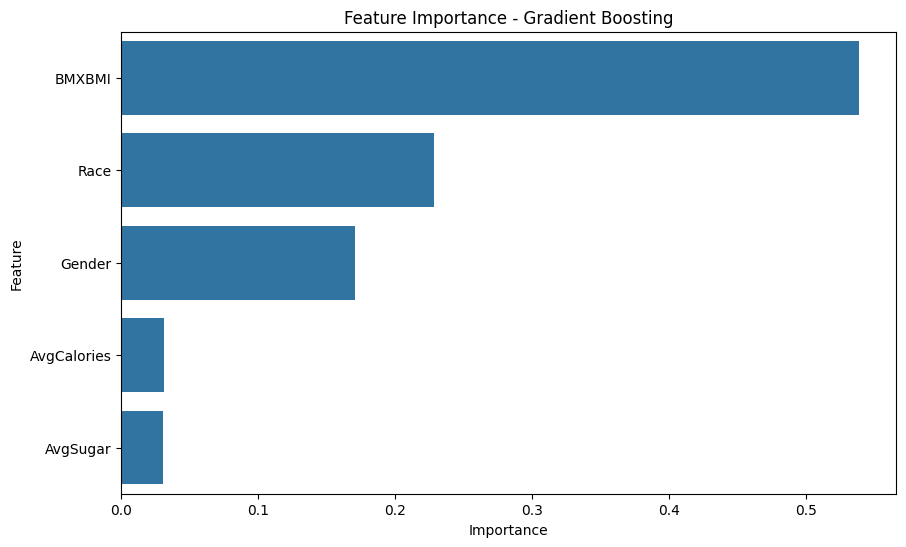

In [ ]:
# Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_diabetes, y_train_diabetes)
gb_y_pred = gb_model.predict(X_test_diabetes)
gb_y_proba = gb_model.predict_proba(X_test_diabetes)[:, 1]

print("\nEvaluation Metrics for Gradient Boosting (Diabetes):")
print(f"Accuracy: {accuracy_score(y_test_diabetes, gb_y_pred):.2f}")
print(f"Precision: {precision_score(y_test_diabetes, gb_y_pred):.2f}")
print(f"Recall: {recall_score(y_test_diabetes, gb_y_pred):.2f}")
print(f"F1 Score: {f1_score(y_test_diabetes, gb_y_pred):.2f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test_diabetes, gb_y_proba):.2f}")

# Feature Importances
if hasattr(gb_model, 'feature_importances_'):
    gb_feature_importances = gb_model.feature_importances_
    gb_features = X.columns
    gb_importance_df = pd.DataFrame({'Feature': gb_features, 'Importance': gb_feature_importances}).sort_values(by='Importance', ascending=False)

    print("\nFeature Importances for Gradient Boosting:")
    print(gb_importance_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=gb_importance_df)
    plt.title('Feature Importance - Gradient Boosting')
    plt.show()

In [ ]:
# Train and evaluate Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_diabetes, y_train_diabetes)
lr_y_pred = lr_model.predict(X_test_diabetes)
lr_y_proba = lr_model.predict_proba(X_test_diabetes)[:, 1]

print("\nEvaluation Metrics for Logistic Regression (Diabetes):")
print(f"Accuracy: {accuracy_score(y_test_diabetes, lr_y_pred):.2f}")
print(f"Precision: {precision_score(y_test_diabetes, lr_y_pred):.2f}")
print(f"Recall: {recall_score(y_test_diabetes, lr_y_pred):.2f}")
print(f"F1 Score: {f1_score(y_test_diabetes, lr_y_pred):.2f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test_diabetes, lr_y_proba):.2f}")



Evaluation Metrics for Logistic Regression (Diabetes):
Accuracy: 0.74
Precision: 0.74
Recall: 0.75
F1 Score: 0.74
ROC-AUC Score: 0.81
